# Data Exploration

## 0. Imports and Settings

In [1]:
import sys
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

## 1. Class Counts

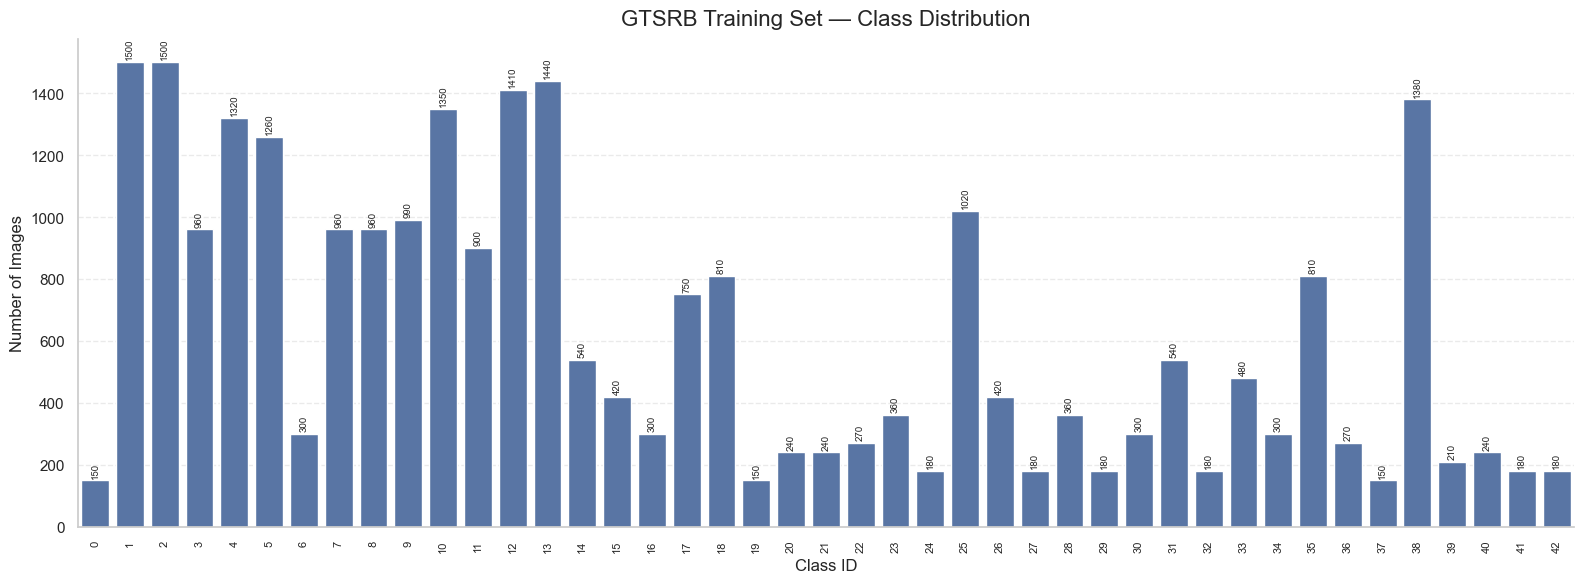

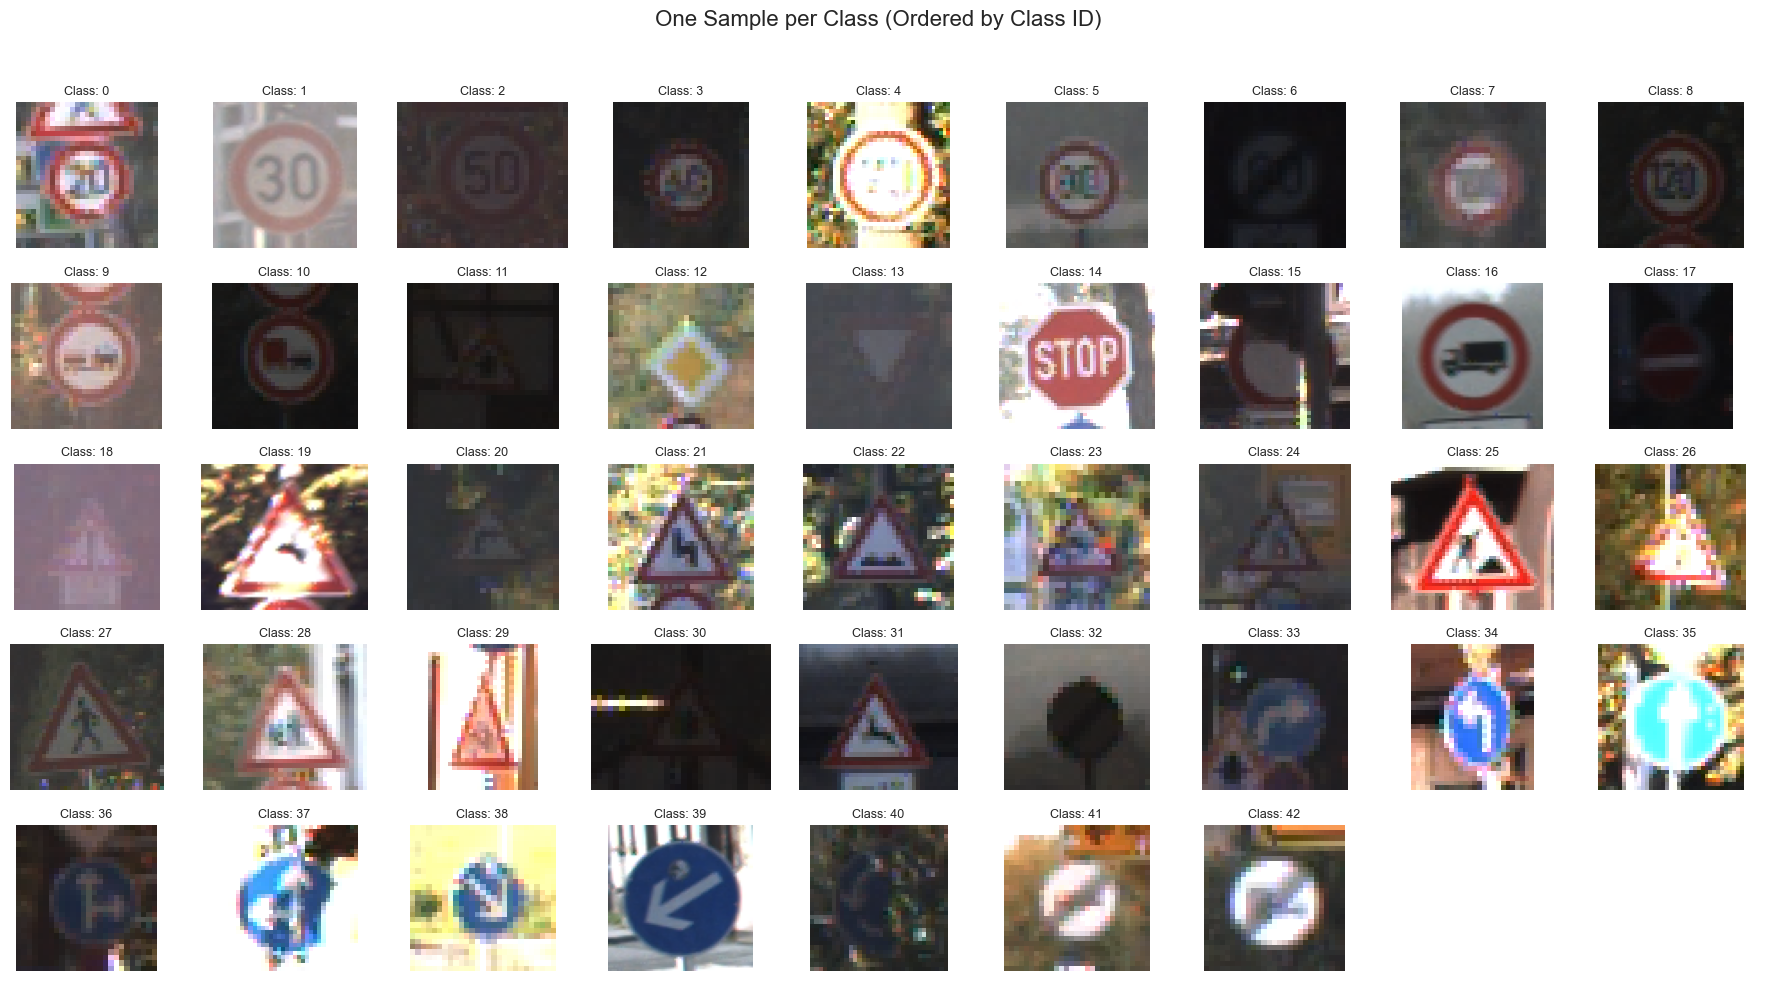

In [2]:
# Load the raw dataset (PIL images)
raw_dataset = torchvision.datasets.GTSRB(root='../data', split='train', download=True)

# Compute Class Distribution
class_counts = np.bincount([sample[1] for sample in raw_dataset], minlength=43)
classes = np.arange(43)

# Professional class distribution plot
sns.set_theme(style='whitegrid', context='notebook')
fig, ax = plt.subplots(figsize=(16, 6))
bar = sns.barplot(x=classes, y=class_counts, ax=ax)
ax.set_title('GTSRB Training Set — Class Distribution', fontsize=16, pad=10)
ax.set_xlabel('Class ID', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_xticks(classes)
ax.set_xticklabels(classes, rotation=90, ha='center', fontsize=8)
ax.grid(axis='y', linestyle='--', alpha=0.4)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Annotate counts on top of bars (small font to reduce clutter)
for patch, count in zip(ax.patches, class_counts):
    ax.annotate(f'{int(count)}',
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha='center', va='bottom', fontsize=7, rotation=90, xytext=(0, 2),
                textcoords='offset points')
plt.tight_layout()
plt.show()

# One sample per class (ordered grid)
sample_by_class = [None] * 43
found = 0
for img, label in raw_dataset:
    if sample_by_class[label] is None:
        sample_by_class[label] = img
        found += 1
        if found == 43:
            break

rows, cols = 5, 9  # 45 slots; two will remain empty
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
fig.suptitle('One Sample per Class (Ordered by Class ID)', fontsize=16)

for idx in range(rows * cols):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    if idx < 43 and sample_by_class[idx] is not None:
        ax.imshow(sample_by_class[idx])
        ax.set_title(f'Class: {idx}', fontsize=9)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

## 2. Visualizing Training Augmentations

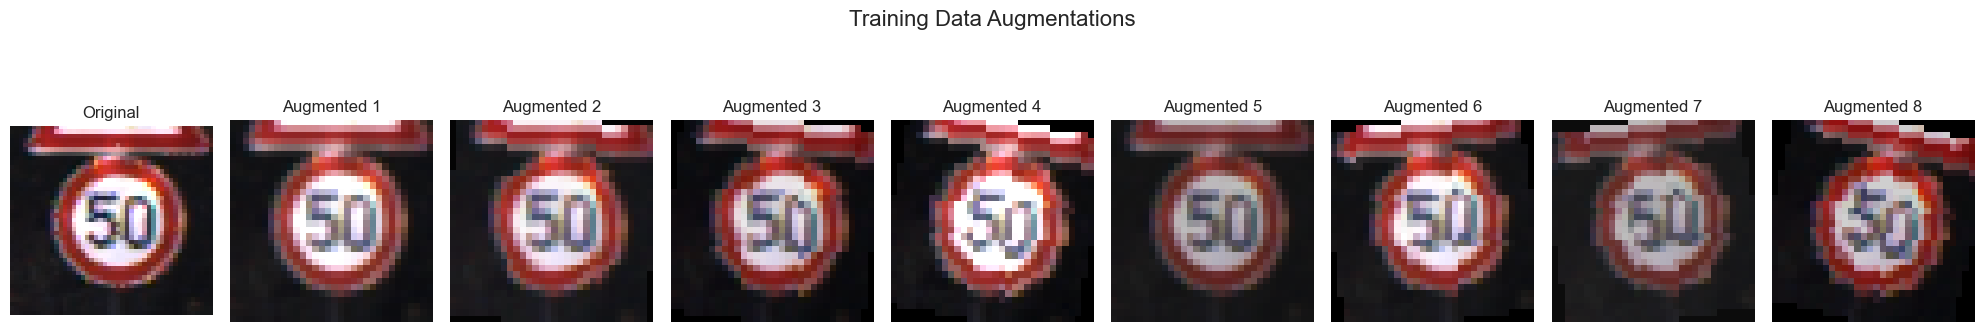

In [3]:
from src.data_loader import make_transforms

# Get the training transformations (without normalization for better visualization)
train_transform, _ = make_transforms()

# Select one sample image (PIL)
sample_idx = 2000  # chosen for a clear, interesting sign
sample_image, _ = raw_dataset[sample_idx]

# Apply the transform multiple times and collect the results (stochastic augments)
num_augs = 8
augmented_images = [train_transform(sample_image) for _ in range(num_augs)]

# Plot the original vs. augmented versions
fig, axes = plt.subplots(1, num_augs + 1, figsize=(20, 4))
fig.suptitle('Training Data Augmentations', fontsize=16)

# Left-most: original image
axes[0].imshow(sample_image)
axes[0].set_title('Original')
axes[0].axis('off')

# Augmented images: tensors in [0,1] -> HxWxC numpy for imshow
for i, aug_img in enumerate(augmented_images):
    arr = aug_img.permute(1, 2, 0).cpu().numpy()
    arr = arr.clip(0, 1)
    axes[i + 1].imshow(arr)
    axes[i + 1].set_title(f'Augmented {i + 1}')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

# 3. Visualizing Robustness Corruptions

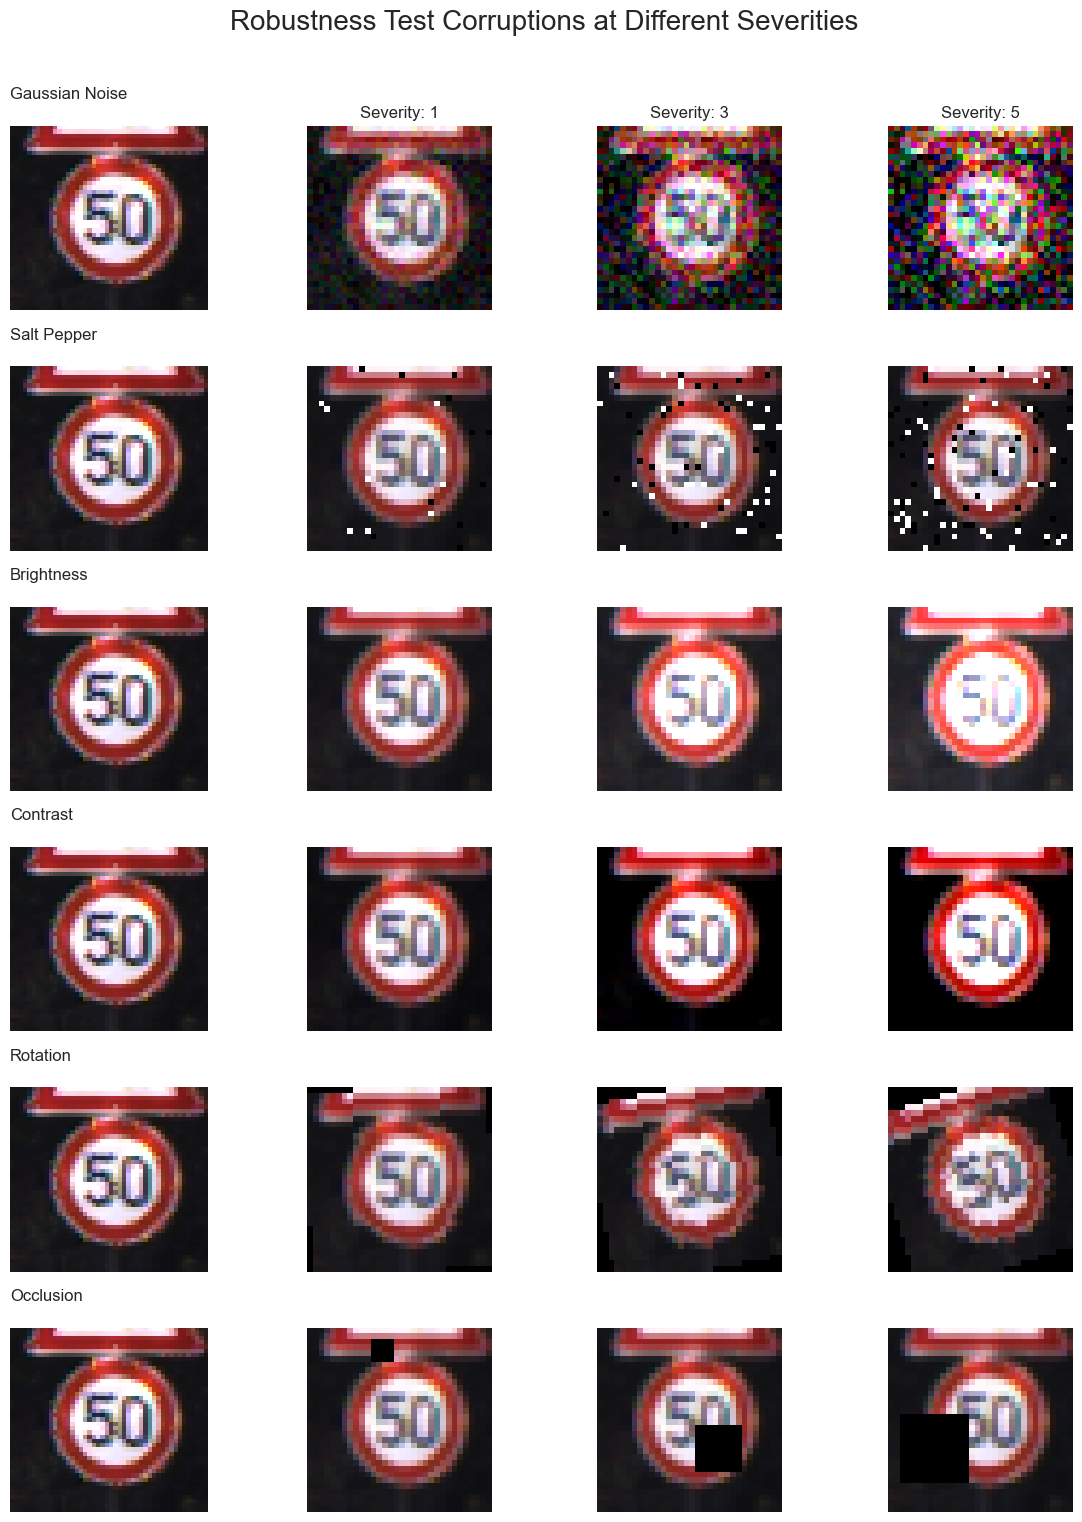

In [4]:
from src.robustness import get_robustness_transform

# Get the same sample image
sample_image, _ = raw_dataset[2000]

corruption_types = [
    'gaussian_noise',
    'salt_pepper',
    'brightness',
    'contrast',
    'rotation',
    'occlusion'
]
severities = [1, 3, 5]  # Low, medium, high

fig, axes = plt.subplots(len(corruption_types), len(severities) + 1, figsize=(12, 16))
fig.suptitle('Robustness Test Corruptions at Different Severities', fontsize=20)

for row, corruption in enumerate(corruption_types):
    # Show original image in the first column for comparison
    axes[row, 0].imshow(sample_image)
    axes[row, 0].set_title(f'{corruption.replace("_", " ").title()}', loc='left', fontsize=12, y=1.1)
    axes[row, 0].axis('off')

    for col, severity in enumerate(severities):
        # Get the corruption transform (includes Resize+ToTensor internally)
        transform = get_robustness_transform(corruption, severity)
        corrupted_img_tensor = transform(sample_image)

        # Prepare for display: tensor [C,H,W] -> numpy [H,W,C], clamp to [0,1]
        arr = corrupted_img_tensor.permute(1, 2, 0).cpu().numpy()
        arr = arr.clip(0, 1)

        # Plot
        ax = axes[row, col + 1]
        ax.imshow(arr)
        if row == 0:  # Add severity titles only for the first row
            ax.set_title(f'Severity: {severity}')
        ax.axis('off')

plt.tight_layout(rect=(0, 0.03, 1, 0.97))
plt.show()